In [1]:
import sys
import os
import nltk
import json
import nest_asyncio
import matplotlib.pyplot as plt
import numpy as np
import torch
import time        
import warnings

from IPython.display import display
from huggingface_hub import login
from llama_cloud_services import LlamaParse
from dotenv import load_dotenv
from context_cite import ContextCiter
from context_cite.utils import aggregate_logit_probs
from context_cite.context_partitioner import SentencePeriodPartitioner
from transformers import AutoTokenizer, AutoModelForCausalLM
from scipy.stats import spearmanr

In [2]:
load_dotenv()
nest_asyncio.apply()
warnings.filterwarnings("ignore")
os.environ['TRANSFORMERS_VERBOSITY'] = 'error'
# login(token=os.getenv("HF_TOKEN"))
# nltk.download('punkt_tab')
parser = LlamaParse(api_key=os.getenv("LLAMA_CLOUD_API_TOKEN"))

In [3]:
document = 'documents/sample.txt'
MODEL_NAME = "Llama-3.2-1B-Instruct"
model_name = "meta-llama/Llama-3.2-1B-Instruct" # 3.2 1B Instruct for faster inference, 3.1 8B for better performance

In [4]:
# docs = parser.load_data(document)
# data = ""
# for doc in docs:
#     if len(doc.text) >= 32:
#         data += doc.text + " "
# len(data)

In [5]:
def plot(cc: ContextCiter, path: str = None):
    pred_logits = cc._pred_logit_probs
    # pred_logits = aggregate_logit_probs(pred_logits)
    actu_logits = cc._actual_logit_probs

    preds = pred_logits.flatten()
    actus = actu_logits.flatten()
    assert len(preds) == len(actus), f"{len(preds)} != {len(actus)}"

    # Compute Spearman correlation without modifying the actual data
    corr, _ = spearmanr(preds, actus)  # ✅ Correct way to compute Spearman correlation

    plt.figure(figsize=(8, 8))
    plt.scatter(preds, actus, alpha=0.3, label="Context ablations")  # Scatter plot

    # Plot y = x reference line
    x_line = np.linspace(min(preds.min(), actus.min()), max(preds.max(), actus.max()), 100)
    plt.plot(x_line, x_line, '--', color='gray', label="y = x")

    # Labels and title
    plt.xlabel("Predicted log-probability")
    plt.ylabel("Actual log-probability")
    plt.title(f"Predicted vs. Actual log-probability\nSpearman correlation: {corr:.2f}")
    plt.legend()
    plt.grid(True)

    if path:
        plt.savefig(path)
    plt.show()

In [6]:
def input_handler(path: str) -> str:
	if path.endswith(".pdf"):
		docs = parser.load_data(path)
		data = ""
		for doc in docs:
			if len(doc.text) >= 32:
				data += doc.text + " "
		return data
	elif path.endswith(".txt"):
		with open(path, "r") as file:
			data = file.read()
		return data
	else:
		raise ValueError("Invalid file format")

In [ ]:
cc = ContextCiter.from_pretrained(
	model_name,
	context=input_handler(document),
	query="What type of GPUs did the authors use in this paper?",
	device="cuda",
	num_ablations=128
)

In [8]:
res = cc.get_attributions(as_dataframe=True, top_k=5)
res

Attributed: The authors used P100 GPUs in this paper.


  0%|          | 0/255 [00:00<?, ?it/s]

,Score,Source
0,11.993,The Transformer allows for significantly more parallelization and can reach a new state of the art in translation quality after being trained for as little as twelve hours on eight P100 GPUs.
1,0.694,"On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature."
2,0.191,We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data.
3,0.078,"Aligning the positions to steps in computation time, they generate a sequence of hidden states ht, as a function of the previous hidden state ht-1 and the input for position t. This inherently sequential nature precludes parallelization within training examples, which becomes critical at longer sequence lengths, as memory constraints limit batching across examples."
4,0.000,"In this work we propose the Transformer, a model architecture eschewing recurrence and instead relying entirely on an attention mechanism to draw global dependencies between input and output."


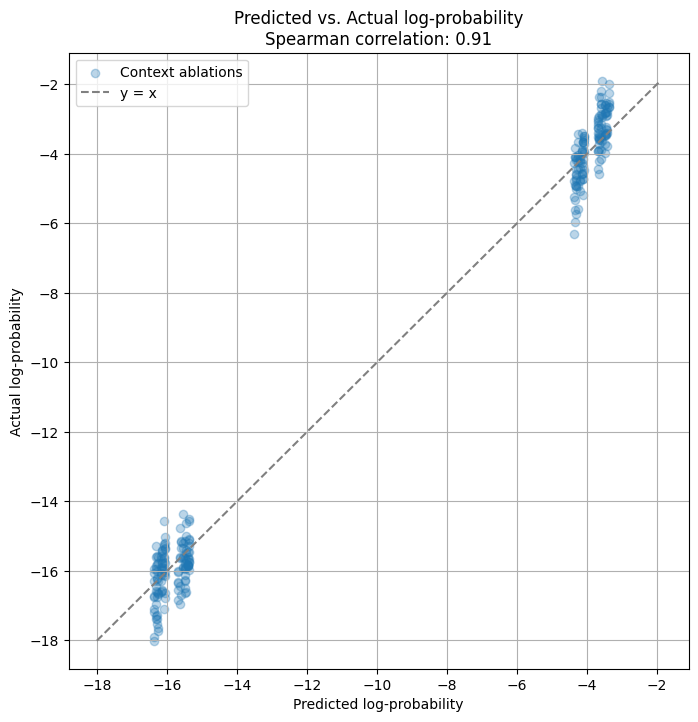

In [9]:
plot(cc)